# Read dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_data = pd.read_csv('./dataset/Google_Stock_Price/Google_Stock_Price_Train.csv').values
test_data = pd.read_csv('./dataset/Google_Stock_Price/Google_Stock_Price_Test.csv').values

# parameter
input_days = 60
epochs = 250
batch_size = 50
offset = 0.
period=50
offset_change = 0.01
RADAM = True
if RADAM:
    from keras_radam import RAdam
    from keras_lookahead import Lookahead
    optimizer = Lookahead(RAdam())
else:
    optimizer = 'adam'
num_classes = 3

Instructions for updating:
Colocations handled automatically by placer.


# Fix data string to float

In [2]:
# the data[4:6] must be fix
def str2float(data):
    length = len(data)
    for i in range(length):
        try:
            data[i] = data[i].replace(',', '')
        except AttributeError:
            data[i] = data[i]
    return np.asarray(data, dtype=np.float)
    
# fix all data in dataset
def fixStr2Float(dataset):
    shape = dataset.shape
    dataset_t = np.zeros((0, shape[-1]), np.float)
    for i, data in enumerate(dataset):
        dataset_t = np.append(dataset_t, np.expand_dims(str2float(data), axis=0), axis=0)
    return dataset_t

# trainsform
train_data_t = fixStr2Float(train_data[:, 1:])
test_data_t = fixStr2Float(test_data[:, 1:])

print(train_data_t.shape)
print(test_data_t.shape)

(1258, 5)
(20, 5)


# My own MinMaxScaler

In [3]:
class MinMaxScaler:
    __min = 0.
    __max = 1.
    __range = 1.
    __feature_range = (0, 1)
    __scale = 1.
    def __init__(self):
        pass
    def getScalerData(self, dataset, offset=0.1, feature_range=(0, 1)):
        data_max = np.max(dataset)
        data_min = np.min(dataset)
        if len(dataset) == 1:
            range_temp = dataset * offset
        else:
            range_temp = (data_max - data_min) * (1 + offset)
        self.__min = data_max - range_temp
        self.__max = data_min + range_temp
        self.__range = self.__max - self.__min
        self.__feature_range = feature_range
        self.__scale = (feature_range[1] - feature_range[0]) / self.__range
        return self.getTransformData(dataset)
    def getTransformData(self, dataset):
        return (dataset - self.__min) * self.__scale + self.__feature_range[0]
    def getInverseData(self, scalerDataset):
        return (scalerDataset - self.__feature_range[0]) / self.__scale + self.__min
    def getParameter(self):
        return self.__min, self.__max, self.__range, self.__feature_range, self.__scale
    def updatePatameter(self, parameter):
        self.__min, self.__max, self.__range, self.__feature_range, self.__scale = parameter

# define create dataset

In [4]:
from tensorflow.keras.utils import to_categorical
def createDataset_global(dataset, day_in=60, day_out=1):
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x.append(dataset[i-day_in:i, :])
        y.append(dataset[i:i+day_out, :])
    return np.asarray(x), np.asarray(y)

def genQuteChange(dataset):
    return (dataset[1:] - dataset[:-1]) / dataset[:-1]

def createDataset_local(dataset, day_in=60, day_out=1, offset=0.1):
    sc = MinMaxScaler()
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x.append(sc.getScalerData(dataset[i-day_in:i, :], offset=offset))
        y.append(sc.getTransformData(dataset[i:i+day_out, :]))
    return np.asarray(x), np.asarray(y)

def createDataset_mix(dataset, day_in=60, day_out=1, offset=0.1):
    sc = MinMaxScaler()
    y_sc = MinMaxScaler()
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x_data = dataset[i-day_in:i, :]
        y_data = dataset[i:i+day_out, :]
        x_mean = np.mean(x_data)
        x.append(sc.getScalerData(x_data, offset=offset))
        y.append((y_data - x_mean) / x_mean)
    return (np.asarray(x), y_sc.getScalerData(np.asarray(y))), y_sc

def createDataset_action(dataset, day_in=60, day_out=1, offset=0.1, offset_change=0.02):
    # 0 : sell, 1 : don't move, 2 : buy 
    sc = MinMaxScaler()
    y_sc = MinMaxScaler()
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x_data = dataset[i-day_in:i, :]
        y_data = dataset[i:i+day_out, :]
        x_mean = np.mean(x_data)
        x.append(sc.getScalerData(x_data, offset=offset))
        change = ((y_data - x_data[:-1]) / x_data[:-1]).item(0)
        if change < -offset_change:
            y.append(0)
        elif change > offset_change:
            y.append(2)
        else:
            y.append(1)
    return np.asarray(x), to_categorical(np.asarray(y), num_classes=num_classes)

# Create training dataset and testing dataset

In [5]:
# append to a big dataset total
dataset = np.append(train_data_t, test_data_t, axis=0)
test_count = len(test_data_t)

# Split dataset to Volume and Open
open_data = dataset[:, :1]
volume_data = dataset[:, -1:]

# use global norm to volume data (with offset)
volume_sc = MinMaxScaler()
volume_norm = volume_sc.getScalerData(volume_data, offset=0.05, feature_range=(0, 1))

# create dataset
volume_dataset = createDataset_global(volume_norm, day_in=input_days)
open_dataset = createDataset_action(dataset[:, :1], day_in=input_days, offset=offset, offset_change=offset_change)

# create total dataset
dataset_x = np.append(open_dataset[0], volume_dataset[0], axis=-1)
dataset_y = open_dataset[1]

# split to train and test dataset
train_x = dataset_x[:-test_count]
train_y = dataset_y[:-test_count, :]
test_x = dataset_x[-test_count-input_days:]
test_y = dataset_y[-test_count-input_days:, :]

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1198, 60, 2) (1198, 3)
(80, 60, 2) (80, 3)


# Create Model

In [6]:
# LSTM Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (input_days, 2), dropout=0.2))
model.add(LSTM(units = 50, return_sequences = True, dropout=0.2))
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 40, activation='relu'))
model.add(Dense(units = 3, activation='softmax'))
model.compile(optimizer = optimizer, loss = 'mean_squared_error')
model.summary()
plot_model(model, 'model.png')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
flatten (Flatten)            (None, 3000)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               384128    
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)       

# Training the model with Open data and Volume data

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
name = 'LSTM_05'
checkpoint_file = './model/' + name + '_check_point/cp-{epoch:04d}.ckpt'
try:
    os.mkdir('./model/' + name + '_check_point/')
except:
    pass

# get what we want
train_input = train_x
train_label = train_y
test_input = test_x
test_label = test_y
# train_label = np.squeeze(train_label, axis=1)
# test_label = np.squeeze(test_label, axis=1)

# create callback function
cp_callback = ModelCheckpoint(checkpoint_file, save_weights_only=True, verbose=1, period=period)

# train the model
train = model.fit(train_input, train_label, epochs=epochs, batch_size=batch_size, callbacks=[cp_callback], 
                  validation_data=(test_input, test_label))

# save model
model.save('./model/' + name + '.h5')

Train on 1198 samples, validate on 80 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/250
1198/1198 [==============================] - 6s 5ms/sample - loss: 0.2189 - val_loss: 0.2147
Epoch 2/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.1951 - val_loss: 0.2013
Epoch 3/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.1510 - val_loss: 0.2182
Epoch 4/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.1268 - val_loss: 0.2314
Epoch 5/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.1170 - val_loss: 0.2243
Epoch 6/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.1173 - val_loss: 0.2027
Epoch 7/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.1099 - val_loss: 0.2063
Epoch 8/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.1092 - val_loss: 0.2228
Epoch 9/250
1198/1198 [==============================] - 4s 3ms/sa

1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0562 - val_loss: 0.1345
Epoch 67/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0558 - val_loss: 0.1356
Epoch 68/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0591 - val_loss: 0.1308
Epoch 69/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0552 - val_loss: 0.1302
Epoch 70/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0562 - val_loss: 0.1327
Epoch 71/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0522 - val_loss: 0.1285
Epoch 72/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0531 - val_loss: 0.1339
Epoch 73/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0521 - val_loss: 0.1318
Epoch 74/250
1198/1198 [==============================] - 4s 4ms/sample - loss: 0.0532 - val_loss: 0.1362
Epoch 75/250
1198/1198 [==============================] - 4

1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0297 - val_loss: 0.1046
Epoch 139/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0269 - val_loss: 0.0824
Epoch 140/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0262 - val_loss: 0.0887
Epoch 141/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0272 - val_loss: 0.0902
Epoch 142/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0280 - val_loss: 0.1174
Epoch 143/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0275 - val_loss: 0.0941
Epoch 144/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0278 - val_loss: 0.0883
Epoch 145/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0298 - val_loss: 0.0973
Epoch 146/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0271 - val_loss: 0.0835
Epoch 147/250
1198/1198 [==========================

Epoch 205/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0161 - val_loss: 0.0714
Epoch 206/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0186 - val_loss: 0.0714
Epoch 207/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0196 - val_loss: 0.0817
Epoch 208/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0160 - val_loss: 0.0769
Epoch 209/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0144 - val_loss: 0.0730
Epoch 210/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0138 - val_loss: 0.0724
Epoch 211/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0176 - val_loss: 0.0789
Epoch 212/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0183 - val_loss: 0.0760
Epoch 213/250
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0194 - val_loss: 0.0732
Epoch 214/250
1198/1198 [============

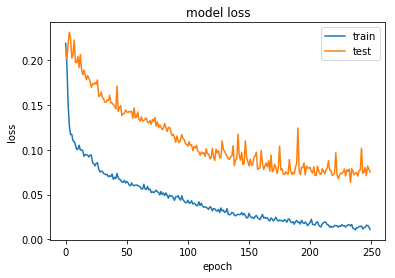

In [8]:
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [9]:
# local data
# model.load_weights('./model/LSTM_05_check_point/cp-{epoch:04d}.ckpt'.format(epoch=250))
testing_data = open_data[-test_count-input_days:]
print(testing_data.shape)
output_action = []
for i in range(1, test_count+1):
    sc = MinMaxScaler()
    test = testing_data[i:i+input_days]
    test_mean = np.mean(test)
    test = sc.getScalerData(test, offset=offset)
    output = np.squeeze(model.predict(np.append(np.expand_dims(test, axis=0), test_x[i:i+1, :, 1:2], axis=-1)), axis=0)
    output_action.append(np.argmax(output))

output_action = np.asarray(output_action)
print(output_action.shape, output_action)

(80, 1)
(20,) [1 1 1 1 2 2 2 2 2 2 2 1 1 1 0 0 2 2 2 2]


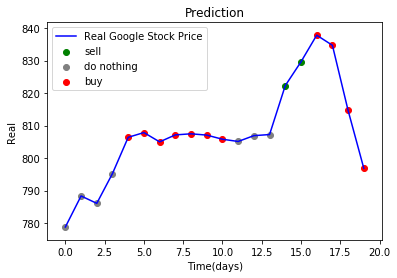

In [10]:
# Visualising the results
plot = test_data_t[:, 0]
sell = np.where(output_action==0)
do_nothing = np.where(output_action==1)
buy = np.where(output_action==2)
plt.plot(plot, color = 'blue', label = 'Real Google Stock Price')
plt.scatter(sell, plot[sell], color = 'green', label = 'sell')
plt.scatter(do_nothing, plot[do_nothing], color = 'gray', label = 'do nothing')
plt.scatter(buy, plot[buy], color = 'red', label = 'buy')
# plt.plot(output_prices, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()